# L96 Carlu Integrator

In this notebook we write an L96 integrator following equations 1a, 1b, 18a and 18b of the Carlu et al. 2019 paper. It has the possibility to simultaneously solve the tangent dynamics.

The Pdfs look good.

In [51]:
# Standard Imports

import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from scipy.stats import gaussian_kde

In [10]:
class Integrator:

    """Integrates the L96 ODEs and it's tangent dynamics simultaneously."""
    def __init__(self, K=36, J=10, h=1, Ff=6, Fs=10, b=10, c=10, dt=0.001,
                 X_init=None, Y_init=None, dx_init=None, dy_init=None, tangent_dynamics=False):

        # Model parameters
        self.K, self.J, self.h, self.Ff, self.Fs, self.b, self.c, self.dt = K, J, h, Ff, Fs, b, c, dt
        self.size = self.K + (self.J * self.K) # Number of variables
        
        self.tangent_dynamics = tangent_dynamics # Do you integrate TLE Simultaneously

        # Step counts
        self.step_count = 0 # Number of integration steps

        # Non-linear Variables
        self.X = np.random.rand(self.K) if X_init is None else X_init.copy() # Random IC if none given
        self.Y = np.random.rand(self.K * self.J) if Y_init is None else Y_init.copy()  # ALL the y's

        # TLE Variables
        self.dx = np.array([i/10000 for i in np.random.rand(self.K)]) if dx_init is None else dx_init.copy()
        self.dy = np.array([i/10000 for i in np.random.rand(self.K * self.J)]) if dy_init is None else dy_init.copy()

    def _rhs_X_dt(self, X, Y):
        """Compute the right hand side of the X-ODE."""

        dXdt = (
                np.roll(X, 1) * (np.roll(X, -1) - np.roll(X, 2)) -
                X + self.Fs - ((self.h * self.c)/self.b) * Y.reshape(self.K, self.J).sum(1)
        )
        return self.dt * dXdt

    def _rhs_Y_dt(self, X, Y):
        """Compute the right hand side of the Y-ODE."""
        dYdt = self.c * (
                          self.b * np.roll(Y, -1) * ( np.roll(Y, 1) - np.roll(Y, -2) )
                       - Y + self.Ff/self.b + (self.h/self.b) * np.repeat(X, self.J) # repeat so x's match y's
               )
        return self.dt * dYdt

    def _rhs_dx_dt(self, X, dx, dy):
        """Computhe rhs of the dx-ODE"""
        ddxdt = (
                    np.roll(dx, 1) * ( np.roll(X, -1) - np.roll(X, 2) )
                    + np.roll(X, 1) * ( np.roll(dx, -1) - np.roll(dx, 2) ) - dx
                   - ((self.h * self.c)/self.b) * dy.reshape(self.K, self.J).sum(1)
        )
        return self.dt * ddxdt

    def _rhs_dy_dt(self, Y, dx, dy):
        """Computhe rhs of the dy-ODE"""
        ddydt = self.c * self.b  * (
                            np.roll(dy, -1) * (np.roll(Y, 1) - np.roll(Y, -2) )
                          + np.roll(Y, -1) * (np.roll(dy, 1) - np.roll(dy, -2) ))
        - self.c * dy + ((self.h * self.c)/self.b) * np.repeat(dx, self.J)
        return self.dt * ddydt

    def _rhs_dt(self, X, Y, dx, dy):
        return self._rhs_X_dt(X, Y), self._rhs_Y_dt(X, Y), self._rhs_dx_dt(X, dx, dy), self._rhs_dy_dt(Y, dx, dy)

    def _step(self):
        """Integrate one time step"""

        # RK Coefficients
        k1_X, k1_Y, k1_dx, k1_dy = self._rhs_dt(self.X, self.Y,
                                                self.dx, self.dy)
        k2_X, k2_Y, k2_dx, k2_dy = self._rhs_dt(self.X + k1_X / 2, self.Y + k1_Y / 2,
                                                self.X + k1_X / 2, self.dy + k1_dy / 2)
        k3_X, k3_Y, k3_dx, k3_dy = self._rhs_dt(self.X + k2_X / 2, self.Y + k2_Y / 2,
                                               self.dx + k2_dx / 2, self.dy + k2_dy / 2)
        k4_X, k4_Y, k4_dx, k4_dy = self._rhs_dt(self.X + k3_X, self.Y + k3_Y,
                                               self.dx + k3_dx / 2, self.dy + k3_dy / 2)

        # Update State
        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        self.Y += 1 / 6 * (k1_Y + 2 * k2_Y + 2 * k3_Y + k4_Y)
        
        if (self.tangent_dynamics):
            self.dx += 1 / 6 * (k1_dx + 2 * k2_dx + 2 * k3_dx + k4_dx)
            self.dy += 1 / 6 * (k1_dy + 2 * k2_dy + 2 * k3_dy + k4_dy)
        self.step_count += 1

    def integrate(self, time, noprog=True):
        """time: how long we integrate for in adimensional time."""
        steps = int(time / self.dt)
        for n in tqdm(range(steps), disable=noprog):
            self._step()

    def set_state(self, x, tangent_x):
        """x is [X, Y]. tangent_x is [dx, dy]"""
        self.X = x[:self.K]
        self.Y = x[self.K:] 
        self.dx = tangent_x[: self.K]
        self.dy = tangent_x[self.K: ] 

    @property
    def state(self):
        """Where we are in phase space."""
        return np.concatenate([self.X, self.Y])

    @property
    def tangent_state(self):
        """Where we are in tangent space"""
        return np.concatenate([self.dx, self.dy])

    @property
    def time(self):
        """a-dimensional time"""
        return self.dt * self.step_count

    @property
    def parameter_dict(self):
        param = {
        'h': self.h, # L96
        'Fs': self.Fs,
        'Ff': self.Ff,
        'c': self.c,
        'J': self.J,
        'K': self.K,
        'Number of variables': self.size,
        'b': self.b,
        'dt': self.dt
        }
        return param

    def reset_count(self):
        """Reset Step count"""
        self.step_count = 0

In [14]:
class TrajectoryObserver():
    """Observes the trajectory of L96 ODE integrator. Dumps to netcdf."""

    def __init__(self, integrator, name='L96 Trajectory'):
        """param, integrator: integrator being observed."""

        # Needed knowledge of the integrator
        self._K = integrator.K
        self._J = integrator.J
        self._parameters = integrator.parameter_dict
        self.scale = integrator.b

        # Trajectory Observation logs
        self.time_obs = [] # Times we've made observations
        self.x_obs = []
        self.y_obs = []
        self.dx_obs = []
        self.dy_obs = []

    def look(self, integrator):
        """Observes trajectory of L96 trajectory"""

        # Note the time
        self.time_obs.append(integrator.time)

        # Making Observations
        self.x_obs.append(integrator.X.copy())
        self.y_obs.append(integrator.Y.copy()/self.scale) # Integrator solves transformed equations
        self.dx_obs.append(integrator.dx.copy())
        self.dy_obs.append(integrator.dy.copy()/self.scale)

    @property
    def observations(self):
        """cupboard: Directory where to write netcdf."""
        if (len(self.x_obs) == 0):
            print('I have no observations! :(')
            return

        dic = {}
        _time = self.time_obs
        dic['X'] = xr.DataArray(self.x_obs, dims=['time', 'K'], name='X',
                                coords = {'time': _time,'K': np.arange(1, 1 + self._K)})
        dic['Y'] = xr.DataArray(self.y_obs, dims=['time', 'KJ'], name='Y',
                                coords = {'time': _time, 'KJ': np.arange(1, 1 + self._K * self._J)})
        dic['dx'] = xr.DataArray(self.x_obs, dims=['time', 'K'], name='dx',
                                coords = {'time': _time,'K': np.arange(1, self._K + 1)})
        dic['dy'] = xr.DataArray(self.y_obs, dims=['time', 'KJ'], name='dy',
                                coords = {'time': _time, 'KJ': np.arange(1, 1 + self._K * self._J)})

        # Slow Variables above fast ones
        dic['X_repeat'] = xr.DataArray(np.repeat(self.x_obs, self._J, axis=1),
                                   dims=['time', 'KJ'], name='X_repeat',
                                    coords = {'time': _time,'KJ': np.arange(1, 1 + self._K * self._J)})# X's above the y's

        return xr.Dataset(dic, attrs= self._parameters)

    def wipe(self):
        """Erases observations"""
        self.time_obs = []
        self.x_obs = []
        self.y_obs = []
        self.dx_obs = []
        self.dy_obs = []

    def dump(self, cupboard):
        """ Saves observations to netcdf and wipes logs.
        cupboard: Directory where to write netcdf."""
        self.observations.to_netcdf(cupboard)
        print(f'Observations written to {cupboard}. Erasing personal log.\n')
        self.wipe()

def make_observations(runner, looker, obs_num, obs_freq, noprog=False):
    """Makes observations given runner and looker.
    runner, integrator object.
    looker, observer object.
    obs_num, how many observations you want.
    obs_freq, adimensional time between observations"""
    for step in tqdm(np.repeat(obs_freq, obs_num), disable=noprog):
        runner.integrate(obs_freq)
        looker.look(runner)

### Collecting some test data from the integrator

In [23]:
runner = Integrator()
runner.integrate(10, noprog=False)

In [24]:
looker = TrajectoryObserver(runner)

In [25]:
make_observations(runner, looker, 10000, 0.01)

In [26]:
looker.observations

<xarray.Dataset>
Dimensions:   (K: 36, KJ: 360, time: 10000)
Coordinates:
  * time      (time) float64 10.01 10.02 10.03 10.04 ... 110.0 110.0 110.0 110.0
  * K         (K) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * KJ        (KJ) int64 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
Data variables:
    X         (time, K) float64 1.747 6.225 4.383 -3.117 ... 5.269 0.09202 4.268
    Y         (time, KJ) float64 0.06049 0.04381 0.03357 ... -0.03425 0.008889
    dx        (time, K) float64 1.747 6.225 4.383 -3.117 ... 5.269 0.09202 4.268
    dy        (time, KJ) float64 0.06049 0.04381 0.03357 ... -0.03425 0.008889
    X_repeat  (time, KJ) float64 1.747 1.747 1.747 1.747 ... 4.268 4.268 4.268
Attributes:
    h:                    1
    Fs:                   10
    Ff:                   6
    c:                    10
    J:                    10
    K:                    36
    Number of variables:  396
    b:                    10
    dt:                   0.001

# L96 Basic Statistics Plots

Here we reproduce some plots from the thesis of Vissio to verify our integrator.

## X Variable PDFs

This corresponds to figure 2.4 in Vissio

In [28]:
# Plotting PDF of X in a single sector

def kde_pdf(samples, title, xlabel=''):
    fig, ax = plt.subplots()
    x_d = np.linspace(samples.min() - 1, samples.max() + 1, 1000) # Grid we evaluate PDF on
    kde = gaussian_kde(samples) # KDE. Using Gaussian ker
    pdf = kde.evaluate(x_d)
    ax.plot(x_d, pdf)
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel(xlabel)
    ax.plot(samples, np.full_like(samples, -0.01), 'k*', label='samples')
    ax.legend()
    ax.grid()
    ax.set_title(title)

In [49]:
data = looker.observations
Xs = [data.X.sel(K = i) for i in np.arange(1, 10)]

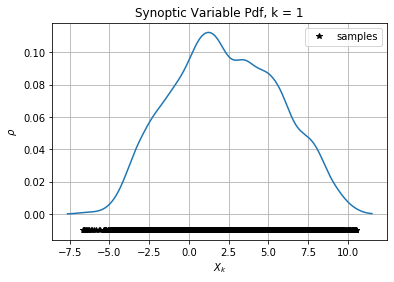

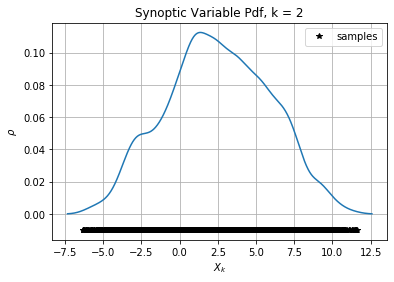

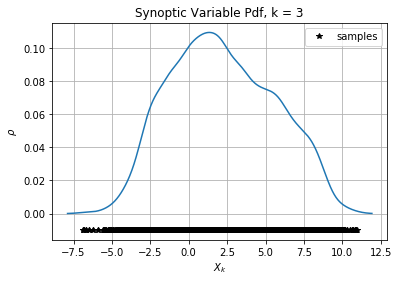

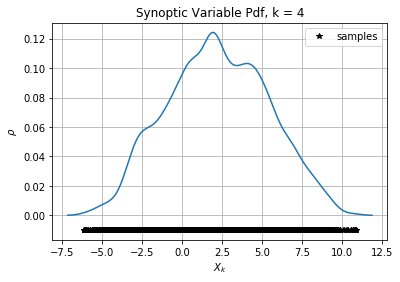

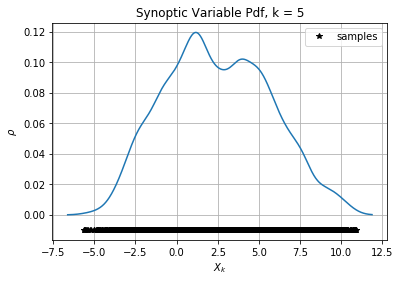

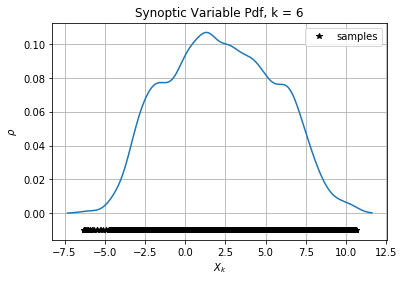

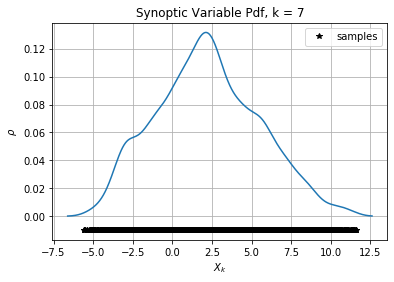

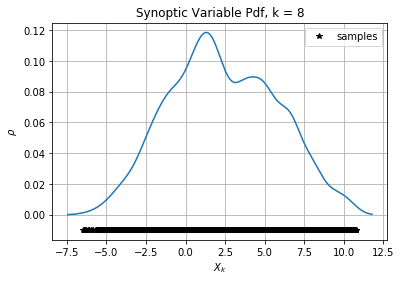

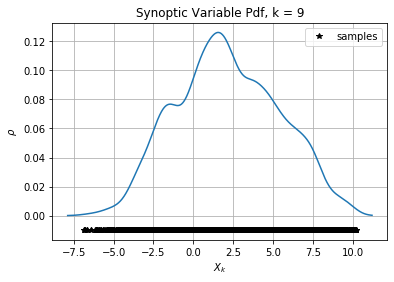

In [47]:
for X in Xs:
    index = X.K.item()
    title = f'Synoptic Variable Pdf, k = {index}'
    kde_pdf(X.values, title, xlabel = '$X_k$')

### Convective Variable Pdfs

In [52]:
Ys = [data.Y.sel(KJ = i) for i in np.arange(1, 360, 35)]

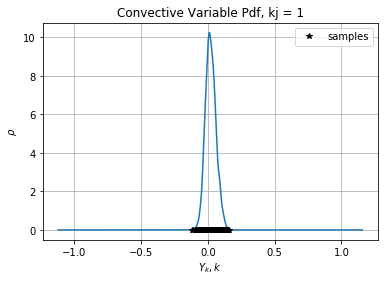

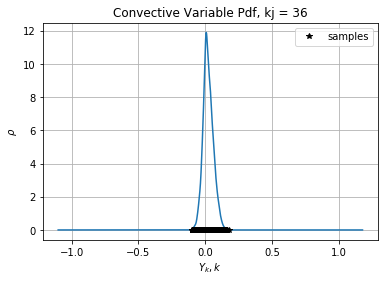

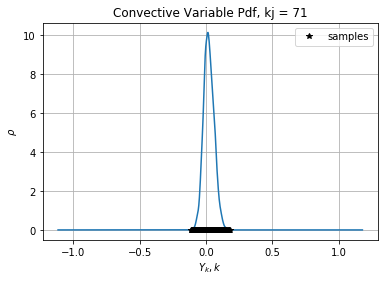

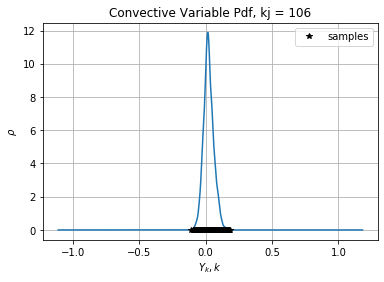

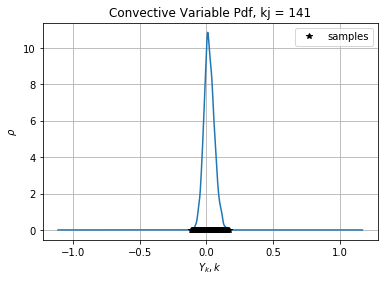

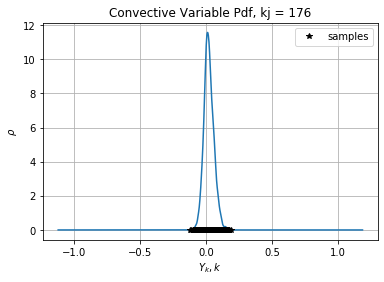

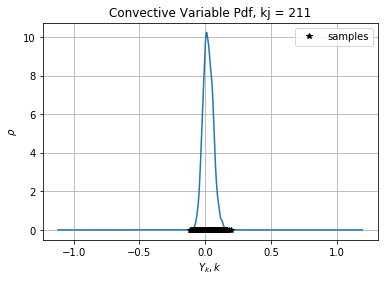

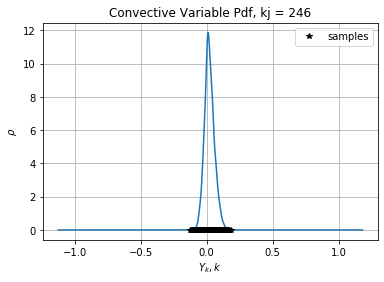

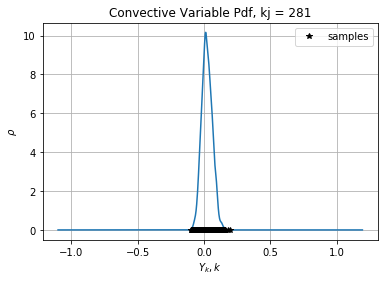

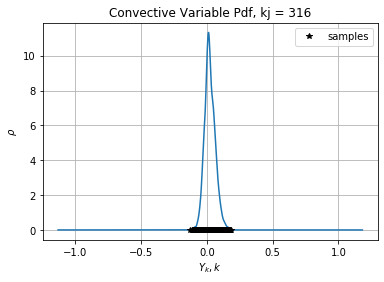

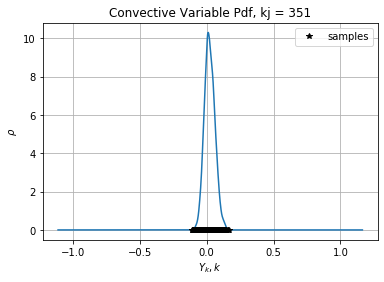

In [50]:
for Y in Ys:
    index = Y.KJ.item()
    title = f'Convective Variable Pdf, kj = {index}'
    kde_pdf(Y.values, title, xlabel = '$Y_k,k$')